In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
from plotting import plot_surf_stat_map, crop_img
import pickle
import seaborn as sns

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def load_pickle(pkl_file):
    pkl_in = open(pkl_file, 'r')
    pkl_dict = pickle.load(pkl_in)
    pkl_in.close()
    return pkl_dict

In [4]:
lh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl100.vtk'
lh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'

rh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl100.vtk'
rh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'

t1_predict_file_0 = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_0.pkl'
t1_predict_file_best = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_best.pkl'


In [5]:
lh_sulc = np.load(lh_sulc_file)
lv, lf, _ = read_vtk(lh_mesh_file)
rh_sulc = np.load(rh_sulc_file)
rv, rf, _ = read_vtk(rh_mesh_file)

In [6]:
t1_predict_0 = load_pickle(t1_predict_file_0)
t1_predict_best = load_pickle(t1_predict_file_best)

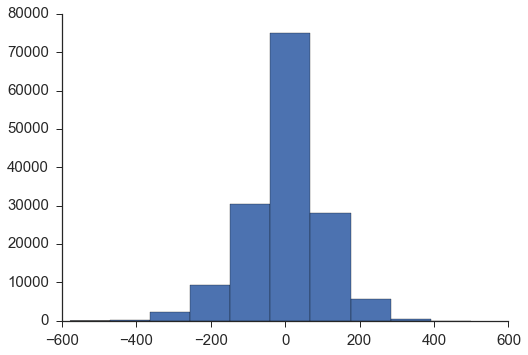

In [7]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
plt.hist(t1_predict_0['residuals']);
sns.despine()

In [133]:
thresh_mask = np.ones(t1_predict_0['residuals'].shape)
upper = np.mean(t1_predict_0['residuals']) + 1*np.std(t1_predict_0['residuals'])
lower = np.mean(t1_predict_0['residuals']) - 1*np.std(t1_predict_0['residuals'])
thresh_mask[np.where(t1_predict_0['residuals']<lower)]=0
thresh_mask[np.where(t1_predict_0['residuals']>upper)]=0
thresh_mask = np.asarray(thresh_mask, dtype='int')
thresh_res = np.copy(t1_predict_0['residuals'])
thresh_res[np.where(thresh_mask==1)]=0

In [134]:
vmax = max(np.abs([thresh_res.min(), thresh_res.max()]))

sns.set_style('white')
sns.set_context('poster')
cropped_res_thresh = []

for data in [thresh_res]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot_lh=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='RdBu_r',
                            vmax=vmax, symmetric_cbar='auto')
        cropped_res_thresh.append(crop_img(plot_lh))
    for (elev, azim) in [(180, 0), (180, 180)]:    
        plot_rh=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='RdBu_r',
                            vmax=vmax, symmetric_cbar='auto')
        cropped_res_thresh.append(crop_img(plot_rh))

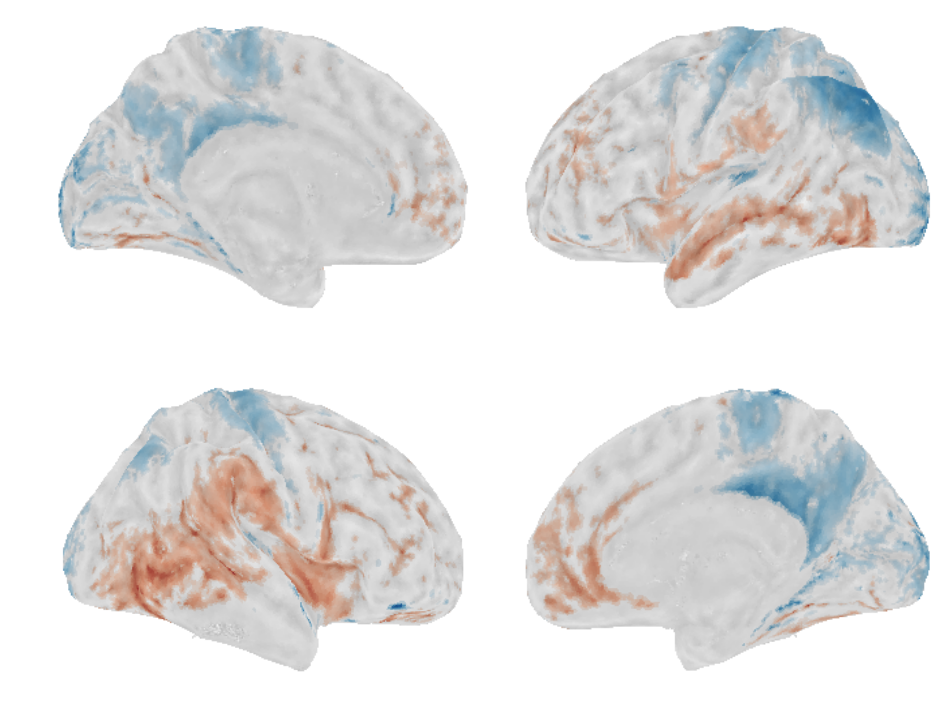

In [135]:
sns.set_style('white')
sns.set_context('poster')

fig = plt.figure(figsize=(20,15))
for img in range(len(cropped_res_thresh)):
    ax = fig.add_subplot(3,2,img+1)
    plt.imshow(cropped_res_thresh[img])
    ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(right=0.65)

In [136]:
import networkx as nx

In [137]:
from graphs import graph_from_mesh

In [138]:
Gl = graph_from_mesh(lv, lf)

In [143]:
sparse_Gl = nx.subgraph(Gl, np.where(thresh_res[:lv.shape[0]]!=0)[0])
subclust_Gl = nx.connected_components(sparse_Gl)
subclusts_Gl = []
len_Gl = []
for sl in subclust_Gl:
    subclusts_Gl.append(sl)
    len_Gl.append(len(sl))
len_Gl = np.asarray(len_Gl)
large_clusts_Gl = []
for ls in np.where(len_Gl>1500)[0]:
    large_clusts_Gl.append(list(subclusts_Gl[ls]))

In [144]:
brain_clusts_Gl = np.zeros(lv.shape[0])
for bc in range(len(large_clusts_Gl)):
    brain_clusts_Gl[large_clusts_Gl[bc]]=bc+1

In [145]:
sns.set_style('white')
sns.set_context('poster')
cropped_clust = []

for data in [brain_clusts_Gl]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot_lh=plot_surf_stat_map(lv, lf, stat_map=data, bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='jet',
                            symmetric_cbar=False, vmin=1, vmax=2)
        cropped_clust.append(crop_img(plot_lh))
    #for (elev, azim) in [(180, 0), (180, 180)]:    
    #    plot_rh=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
    #                        elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='RdBu_r',
    #                       vmax=vmax, symmetric_cbar='auto')
    #   cropped_res_thresh.append(crop_img(plot_rh))

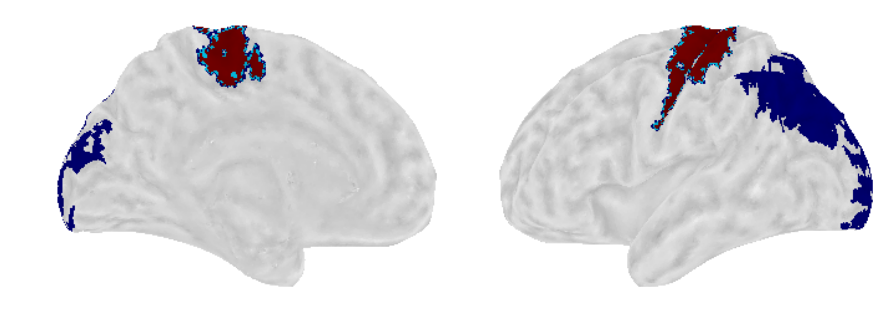

In [146]:
sns.set_style('white')
sns.set_context('poster')

fig = plt.figure(figsize=(20,5))
for img in range(len(cropped_clust)):
    ax = fig.add_subplot(1,2,img+1)
    plt.imshow(cropped_clust[img])
    ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(right=0.65)